In [7]:
import math
from sklearn import neighbors
import os
import os.path
import pickle
from PIL import Image, ImageDraw
import face_recognition
from face_recognition.face_recognition_cli import image_files_in_folder

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
import numpy as np
import cv2

In [8]:
import face_recognition
import cv2
import numpy as np

import math
from sklearn import neighbors
import os
import os.path
import pickle

import urllib.request

import time


def predict(X_img, knn_clf=None, model_path=None, distance_threshold=0.6):
    """
    Recognizes faces in given image using a trained KNN classifier

    :param knn_clf: (optional) a knn classifier object. if not specified, model_save_path must be specified.
    :param model_path: (optional) path to a pickled knn classifier. if not specified, model_save_path must be knn_clf.
    :param distance_threshold: (optional) distance threshold for face classification. the larger it is, the more chance
           of mis-classifying an unknown person as a known one.
    :return: a list of names and face locations for the recognized faces in the image: [(name, bounding box), ...].
        For faces of unrecognized persons, the name 'unknown' will be returned.
    """

    if knn_clf is None and model_path is None:
        raise Exception(
            "Must supply knn classifier either thourgh knn_clf or model_path")

    # Load a trained KNN model (if one was passed in)
    if knn_clf is None:
        with open(model_path, 'rb') as f:
            knn_clf = pickle.load(f)

    # Load image file and find face locations
    X_face_locations = face_recognition.face_locations(X_img)

    # If no faces are found in the image, return an empty result.
    if len(X_face_locations) == 0:
        return []

    # Find encodings for faces in the test iamge
    faces_encodings = face_recognition.face_encodings(
        X_img, known_face_locations=X_face_locations)

    # Use the KNN model to find the best matches for the test face
    closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=1)
    are_matches = [closest_distances[0][i][0] <=
                   distance_threshold for i in range(len(X_face_locations))]

    # Predict classes and remove classifications that aren't within the threshold
    return [(pred, loc) if rec else ("unknown", loc) for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_face_locations, are_matches)]

Training time: 293.0427 seconds
Training size: 150
Prediction time: 0.6029 seconds
[('Nhi', (142, 414, 365, 191))]
Nhi


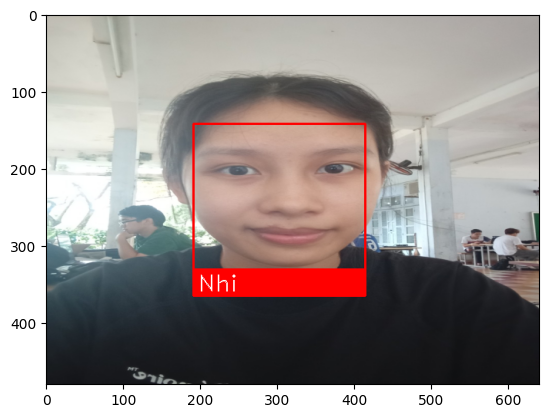

In [21]:
from pyexpat import model
import time

train_dir = "D:\code\Python\PBL5\Learing-face-recognition\TrainImages"
verbose = False

X = []
y = []

tic = time.perf_counter()

# Loop through each person in the training set
for class_dir in os.listdir(train_dir):
    if verbose:
        print(class_dir)
    if not os.path.isdir(os.path.join(train_dir, class_dir)):
        continue
    if verbose:
        print(os.path.join(train_dir, class_dir))

    # Loop through each training image for the current person
    for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
        if verbose:
            print(img_path)
        image = face_recognition.load_image_file(img_path)
        face_bounding_boxes = face_recognition.face_locations(image)

        if len(face_bounding_boxes) != 1:
            # If there are no people (or too many people) in a training image, skip the image.
            if verbose:
                print("Image {} not suitable for training: {}".format(img_path, "Didn't find a face" if len(
                    face_bounding_boxes) < 1 else "Found more than one face"))
        else:
            # Add face encoding for current image to the training set
            X.append(face_recognition.face_encodings(
                    image, known_face_locations=face_bounding_boxes)[0])
            y.append(class_dir)
            if verbose:
                print(class_dir + " Added to database")
            
knn_algo = "ball_tree"
n_neighbors = None
# Determine how many neighbors to use for weighting in the KNN classifier
if n_neighbors is None:
    n_neighbors = int(round(math.sqrt(len(X))))
    if verbose:
        print("Chose n_neighbors automatically:", n_neighbors)

# Create and train the KNN classifier
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
knn_clf.fit(X, y)

toc = time.perf_counter()
print(f"Training time: {toc - tic:0.4f} seconds")

print(f"Training size: {len(X)}")

#-----------------------------------------------------------------------------------------------------

img = cv2.imread(f'TestImages/Nhi/1b0c1e7a6321b27feb3099.jpg')
verbose = False

if verbose:
    print("Loaded image")

width = 640
height = 480
dim = (width, height)

# resize image
resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

# rgb_frame = resized[:, :, ::-1]
rgb_frame = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

tic = time.perf_counter()

predictions = predict(
    rgb_frame, knn_clf=knn_clf , distance_threshold=0.5)

toc = time.perf_counter()
print(f"Prediction time: {toc - tic:0.4f} seconds")

print(predictions)

for name, (top, right, bottom, left) in predictions:
    print(name)
    # Draw a box around the face
    cv2.rectangle(resized, (left, top),
                    (right, bottom), (0, 0, 255), 2)

    # Draw a label with a name below the face
    cv2.rectangle(resized, (left, bottom - 35),
                    (right, bottom), (0, 0, 255), cv2.FILLED)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(resized, name, (left + 6, bottom - 6),
                font, 1.0, (255, 255, 255), 1)

img2 = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
plt.imshow(img2)

In [24]:
from sklearn import metrics

test_dir = "D:\code\Python\PBL5\Learing-face-recognition\TestImages"
verbose = False



# Loop through each person in the training set
for class_dir in os.listdir(test_dir):
    if verbose:
        print(class_dir)
    if not os.path.isdir(os.path.join(test_dir, class_dir)):
        continue
    if verbose:
        print(os.path.join(test_dir, class_dir))
        
    X_test = []
    y_test = []

    # Loop through each training image for the current person
    for img_path in image_files_in_folder(os.path.join(test_dir, class_dir)):
        if verbose:
            print(img_path)
        image = face_recognition.load_image_file(img_path)
        face_bounding_boxes = face_recognition.face_locations(image)

        if len(face_bounding_boxes) != 1:
            # If there are no people (or too many people) in a training image, skip the image.
            if verbose:
                print("Image {} not suitable for training: {}".format(img_path, "Didn't find a face" if len(
                    face_bounding_boxes) < 1 else "Found more than one face"))
        else:
            # Add face encoding for current image to the training set
            X_test.append(face_recognition.face_encodings(
                    image, known_face_locations=face_bounding_boxes)[0])
            y_test.append(class_dir)
            if verbose:
                print(class_dir + " Added to database")
    
    y_pred = knn_clf.predict(X_test)
    print(f"Precision of predicting {class_dir}: {metrics.precision_score(y_test, y_pred, average='micro') * 100}%")



Precision of predicting Cong_Anh: 100.0%
Precision of predicting Ngoc: 100.0%
Precision of predicting Nhi: 100.0%
Precision of predicting Truong: 100.0%


Loaded image
Prediction time: 0.7249 seconds
[('Nhi', (142, 414, 365, 191))]
Nhi


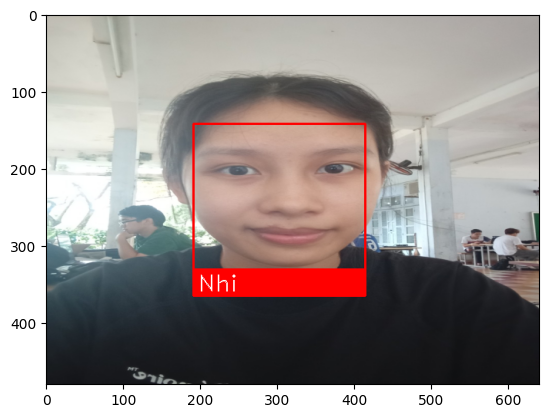

In [20]:
img = cv2.imread(f'TestImages/Nhi/1b0c1e7a6321b27feb3099.jpg')
verbose = True

if verbose:
    print("Loaded image")

width = 640
height = 480
dim = (width, height)

# resize image
resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

# rgb_frame = resized[:, :, ::-1]
rgb_frame = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

tic = time.perf_counter()

predictions = predict(
    rgb_frame, model_path="trained_knn_model.clf", distance_threshold=0.5)

toc = time.perf_counter()
print(f"Prediction time: {toc - tic:0.4f} seconds")

print(predictions)

for name, (top, right, bottom, left) in predictions:
    print(name)
    # Draw a box around the face
    cv2.rectangle(resized, (left, top),
                    (right, bottom), (0, 0, 255), 2)

    # Draw a label with a name below the face
    cv2.rectangle(resized, (left, bottom - 35),
                    (right, bottom), (0, 0, 255), cv2.FILLED)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(resized, name, (left + 6, bottom - 6),
                font, 1.0, (255, 255, 255), 1)

img2 = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
plt.imshow(img2)

In [2]:
train_dir = "D:\code\Python\PBL5\Learing-face-recognition\TrainImages"
verbose = False

X = []
y = []

# Loop through each person in the training set
for class_dir in os.listdir(train_dir):
    print(class_dir)
    if not os.path.isdir(os.path.join(train_dir, class_dir)):
        continue
    print(os.path.join(train_dir, class_dir))

    # Loop through each training image for the current person
    for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
        print(img_path)
        image = face_recognition.load_image_file(img_path)
        face_bounding_boxes = face_recognition.face_locations(image)

        if len(face_bounding_boxes) != 1:
            # If there are no people (or too many people) in a training image, skip the image.
            if verbose:
                print("Image {} not suitable for training: {}".format(img_path, "Didn't find a face" if len(
                    face_bounding_boxes) < 1 else "Found more than one face"))
        else:
            # Add face encoding for current image to the training set
            X.append(face_recognition.face_encodings(
                    image, known_face_locations=face_bounding_boxes)[0])
            y.append(class_dir)
            print(class_dir + " Added to database")

Cong_Anh
D:\code\Python\PBL5\Learing-face-recognition\TrainImages\Cong_Anh
D:\code\Python\PBL5\Learing-face-recognition\TrainImages\Cong_Anh\z4206076130622_165cf26e339a8c6104fc2ea7ec24051b.jpg
Cong_Anh Added to database
D:\code\Python\PBL5\Learing-face-recognition\TrainImages\Cong_Anh\z4206076133620_1f05483e431ae886f84ddf0c6d2a85de.jpg
Cong_Anh Added to database
D:\code\Python\PBL5\Learing-face-recognition\TrainImages\Cong_Anh\z4206076140309_633e6e2e7cb603c198ddf40c964b0561.jpg
Cong_Anh Added to database
D:\code\Python\PBL5\Learing-face-recognition\TrainImages\Cong_Anh\z4206076141113_8a3b24fe9dbfeb593fd5d5f68cc7b5be.jpg
Cong_Anh Added to database
D:\code\Python\PBL5\Learing-face-recognition\TrainImages\Cong_Anh\z4206076145652_f19bd777bf60399e977e4f4272f74cc0.jpg
Cong_Anh Added to database
D:\code\Python\PBL5\Learing-face-recognition\TrainImages\Cong_Anh\z4206076145653_a16531195b85c593ac6aeaa2764e578a.jpg
Cong_Anh Added to database
D:\code\Python\PBL5\Learing-face-recognition\TrainImage

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

In [4]:
knn_algo = "ball_tree"
n_neighbors = None
# Determine how many neighbors to use for weighting in the KNN classifier
if n_neighbors is None:
    n_neighbors = int(round(math.sqrt(len(X))))
    if verbose:
        print("Chose n_neighbors automatically:", n_neighbors)

# Create and train the KNN classifier
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
y_pred_knn = knn_clf.fit(X_train, y_train).predict(X_test)

gnb = GaussianNB()
y_pred_gnb = gnb.fit(X_train, y_train).predict(X_test)


Chose n_neighbors automatically: 11


In [6]:
print("Accuracy_score KNN: {}".format(accuracy_score(y_test,y_pred_knn)))
print("Accuracy_score gnb: {}".format(accuracy_score(y_test,y_pred_gnb)))

Accuracy_score KNN: 0.9655172413793104
Accuracy_score gnb: 0.9827586206896551


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, random_state=0)

knn_algo = "ball_tree"
n_neighbors = None
# Determine how many neighbors to use for weighting in the KNN classifier
if n_neighbors is None:
    n_neighbors = int(round(math.sqrt(len(X))))
    if verbose:
        print("Chose n_neighbors automatically:", n_neighbors)

# Create and train the KNN classifier
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
y_pred_knn = knn_clf.fit(X_train, y_train).predict(X_test)

gnb = GaussianNB()
y_pred_gnb = gnb.fit(X_train, y_train).predict(X_test)

print("Accuracy_score KNN: {}".format(accuracy_score(y_test,y_pred_knn)))
print("Accuracy_score gnb: {}".format(accuracy_score(y_test,y_pred_gnb)))

Chose n_neighbors automatically: 11
Accuracy_score KNN: 0.8924731182795699
Accuracy_score gnb: 0.8387096774193549


In [8]:
sumKNN = 0.0
sumGNB = 0.0
for i in range(10):
    X_train,X_test,y_train,y_test=train_test_split(X, y,test_size=0.5, random_state=i, stratify=y)

    knn_algo = "ball_tree"
    n_neighbors = None
    # Determine how many neighbors to use for weighting in the KNN classifier
    if n_neighbors is None:
        n_neighbors = int(round(math.sqrt(len(X))))
        if verbose:
            print("Chose n_neighbors automatically:", n_neighbors)

    # Create and train the KNN classifier
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    y_pred_knn = knn_clf.fit(X_train, y_train).predict(X_test)

    gnb = GaussianNB()
    y_pred_gnb = gnb.fit(X_train, y_train).predict(X_test)
    
    sumKNN += accuracy_score(y_test,y_pred_knn)
    sumGNB += accuracy_score(y_test,y_pred_gnb)
    
print("AVG KNN: {}".format(sumKNN/10))
print("AVG gnb: {}".format(sumGNB/10))

Chose n_neighbors automatically: 11
Chose n_neighbors automatically: 11
Chose n_neighbors automatically: 11
Chose n_neighbors automatically: 11
Chose n_neighbors automatically: 11
Chose n_neighbors automatically: 11
Chose n_neighbors automatically: 11
Chose n_neighbors automatically: 11
Chose n_neighbors automatically: 11
Chose n_neighbors automatically: 11
AVG KNN: 0.9413793103448276
AVG gnb: 0.9327586206896552


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Split your data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Define a list of models to compare
models = [
    neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance'),
    GaussianNB(),
    DecisionTreeClassifier(),
]

# Train and evaluate each model on the validation set
best_model = None
best_accuracy = 0.0
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Accuracy of {type(model).__name__}: {accuracy}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

# Evaluate the final performance of the selected model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final accuracy of {type(best_model).__name__}: {accuracy}")

Accuracy of KNeighborsClassifier: 1.0
Accuracy of GaussianNB: 1.0
Accuracy of DecisionTreeClassifier: 1.0
Accuracy of RandomForestClassifier: 1.0
Accuracy of SVC: 0.9428571428571428
Accuracy of MLPClassifier: 1.0
Final accuracy of KNeighborsClassifier: 1.0


In [13]:
# Split your data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

knn_algo = "ball_tree"
n_neighbors = None
# Determine how many neighbors to use for weighting in the KNN classifier
if n_neighbors is None:
    n_neighbors = int(round(math.sqrt(len(X))))
    if verbose:
        print("Chose n_neighbors automatically:", n_neighbors)

# Create and train the KNN classifier
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    
# Define a list of models to compare
models = [
    knn_clf,
    GaussianNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    MLPClassifier(max_iter=500)
]



Chose n_neighbors automatically: 11


In [14]:
from sklearn import metrics

In [26]:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"Precision of {type(model).__name__}: {metrics.precision_score(y_val, y_pred, average='micro')}")

Precision of KNeighborsClassifier: 1.0
Precision of GaussianNB: 1.0
Precision of DecisionTreeClassifier: 0.9142857142857143
Precision of RandomForestClassifier: 1.0
Precision of SVC: 0.9428571428571428
Precision of MLPClassifier: 1.0


In [32]:
# Split your data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

knn_algo = "ball_tree"
n_neighbors = None
# Determine how many neighbors to use for weighting in the KNN classifier
if n_neighbors is None:
    n_neighbors = int(round(math.sqrt(len(X))))
    if verbose:
        print("Chose n_neighbors automatically:", n_neighbors)

# Create and train the KNN classifier
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')

model = knn_clf

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy of {type(model).__name__}: {accuracy}")
print(f"Precision of {type(model).__name__}: {metrics.precision_score(y_val, y_pred, average='micro')}")

Chose n_neighbors automatically: 11
Accuracy of KNeighborsClassifier: 1.0
Precision of KNeighborsClassifier: 1.0


In [33]:
# Split your data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)

knn_algo = "ball_tree"
n_neighbors = None
# Determine how many neighbors to use for weighting in the KNN classifier
if n_neighbors is None:
    n_neighbors = int(round(math.sqrt(len(X))))
    if verbose:
        print("Chose n_neighbors automatically:", n_neighbors)

# Create and train the KNN classifier
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')

model = knn_clf

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy of {type(model).__name__}: {accuracy}")
print(f"Precision of {type(model).__name__}: {metrics.precision_score(y_val, y_pred, average='micro')}")

Chose n_neighbors automatically: 11
Accuracy of KNeighborsClassifier: 0.9655172413793104
Precision of KNeighborsClassifier: 0.9655172413793104


In [34]:
# Split your data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.7, random_state=42)

knn_algo = "ball_tree"
n_neighbors = None
# Determine how many neighbors to use for weighting in the KNN classifier
if n_neighbors is None:
    n_neighbors = int(round(math.sqrt(len(X))))
    if verbose:
        print("Chose n_neighbors automatically:", n_neighbors)

# Create and train the KNN classifier
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')

model = knn_clf

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy of {type(model).__name__}: {accuracy}")
print(f"Precision of {type(model).__name__}: {metrics.precision_score(y_val, y_pred, average='micro')}")

Chose n_neighbors automatically: 11
Accuracy of KNeighborsClassifier: 0.8902439024390244
Precision of KNeighborsClassifier: 0.8902439024390244


In [35]:
# Split your data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.9, random_state=42)

knn_algo = "ball_tree"
n_neighbors = None
# Determine how many neighbors to use for weighting in the KNN classifier
if n_neighbors is None:
    n_neighbors = int(round(math.sqrt(len(X))))
    if verbose:
        print("Chose n_neighbors automatically:", n_neighbors)

# Create and train the KNN classifier
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')

model = knn_clf

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy of {type(model).__name__}: {accuracy}")
print(f"Precision of {type(model).__name__}: {metrics.precision_score(y_val, y_pred, average='micro')}")

Chose n_neighbors automatically: 11
Accuracy of KNeighborsClassifier: 0.7333333333333333
Precision of KNeighborsClassifier: 0.7333333333333333


In [36]:
import face_recognition
import cv2
import numpy as np

import math
from sklearn import neighbors
import os
import os.path
import pickle

import urllib.request


def predict(X_img, knn_clf=None, model_path=None, distance_threshold=0.6):
    """
    Recognizes faces in given image using a trained KNN classifier

    :param knn_clf: (optional) a knn classifier object. if not specified, model_save_path must be specified.
    :param model_path: (optional) path to a pickled knn classifier. if not specified, model_save_path must be knn_clf.
    :param distance_threshold: (optional) distance threshold for face classification. the larger it is, the more chance
           of mis-classifying an unknown person as a known one.
    :return: a list of names and face locations for the recognized faces in the image: [(name, bounding box), ...].
        For faces of unrecognized persons, the name 'unknown' will be returned.
    """

    if knn_clf is None and model_path is None:
        raise Exception(
            "Must supply knn classifier either thourgh knn_clf or model_path")

    # Load a trained KNN model (if one was passed in)
    if knn_clf is None:
        with open(model_path, 'rb') as f:
            knn_clf = pickle.load(f)

    # Load image file and find face locations
    X_face_locations = face_recognition.face_locations(X_img)

    # If no faces are found in the image, return an empty result.
    if len(X_face_locations) == 0:
        return []

    # Find encodings for faces in the test iamge
    faces_encodings = face_recognition.face_encodings(
        X_img, known_face_locations=X_face_locations)

    # Use the KNN model to find the best matches for the test face
    closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=1)
    are_matches = [closest_distances[0][i][0] <=
                   distance_threshold for i in range(len(X_face_locations))]

    # Predict classes and remove classifications that aren't within the threshold
    return [(pred, loc) if rec else ("unknown", loc) for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_face_locations, are_matches)]

In [44]:
if __name__ == '__main__':
    with urllib.request.urlopen("https://scontent.fsgn2-8.fna.fbcdn.net/v/t39.30808-6/343225498_1035243164120441_123985157089892242_n.jpg?_nc_cat=102&ccb=1-7&_nc_sid=8bfeb9&_nc_ohc=87HgxorUtRgAX_2q1XA&_nc_ht=scontent.fsgn2-8.fna&oh=00_AfA3d8Bs_ISVk1KA4suKSMUqEYFrrEzyhOF6OrkLFcDRpA&oe=64795B23") as url:
        arr = np.asarray(bytearray(url.read()), dtype=np.uint8)
        img = cv2.imdecode(arr, -1)  # 'Load it as it is'

    print("Loaded image")

    width = 640
    height = 480
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

    rgb_frame = resized[:, :, ::-1]

    predictions = predict(
        rgb_frame, model_path="trained_knn_model.clf", distance_threshold=0.4)

    print(predictions)

Loaded image
[('Truong', (150, 287, 305, 132))]
